In [1]:
import os, sys

if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.upload()
    os.system('mkdir ~/.kaggle')
    os.system('mv ./kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')
    os.system('kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')
    os.system('unzip diabetic-retinopathy-224x224-gaussian-filtered.zip')
    root_address = '.'
else:
    root_address = '../input/diabetic-retinopathy-224x224-gaussian-filtered'

Saving kaggle.json to kaggle.json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [5]:
data_address = f'{root_address}/train.csv'
data = pd.read_csv(data_address)
data.head()


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: xlabel='diagnosis', ylabel='count'>

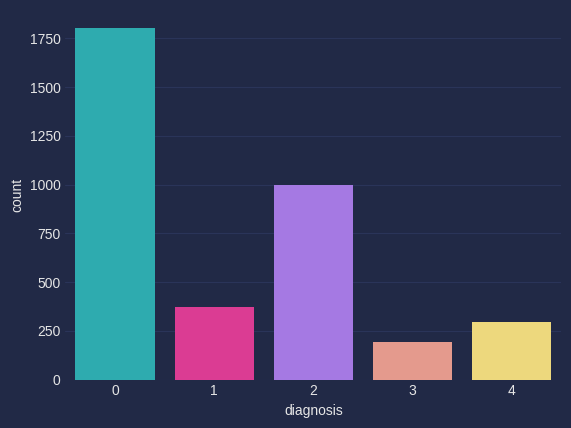

In [6]:
sns.countplot(
    data=data, 
    x='diagnosis'
)

<Axes: xlabel='diagnosis', ylabel='count'>

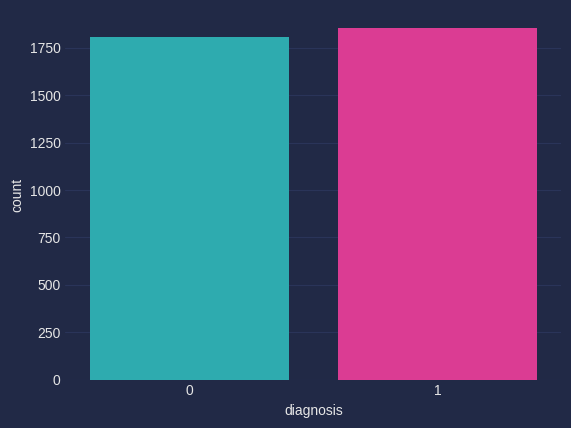

In [7]:
data2 = data.copy()

data2['diagnosis'] = data2['diagnosis'] > 0
data2['diagnosis'] = data2['diagnosis'].astype('int32')

sns.countplot(data=data2, x='diagnosis')

In [8]:
test_frac, val_frac = 0.25, 0.15

_, val = train_test_split(
    data, 
    test_size=val_frac, 
    stratify=data['diagnosis']
)

train, test = train_test_split(
    _, 
    test_size=test_frac/(1-val_frac),
    stratify=_['diagnosis']
)

print(f'{train.shape}, {test.shape}, {val.shape}\n')


(2196, 2), (916, 2), (550, 2)



        id_code  diagnosis status
0  000c1434d8d7          2   None
1  001639a390f0          4   None
2  0024cdab0c1e          1   None
3  002c21358ce6          0   None
4  005b95c28852          0   None 



<Axes: xlabel='status', ylabel='Percent'>

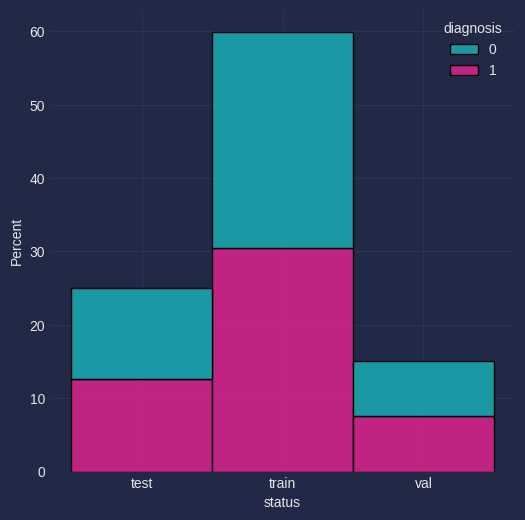

In [10]:
data['status'] = None

for name, source in zip(['train', 'test', 'val'], [train, test, val]):
    for j in source.index:
        data2.at[j, 'status'] = name

print(data.head(), '\n')

fig = plt.subplots(figsize=(6, 6))

sns.histplot(
    data=data2, 
    x='status', 
    hue='diagnosis', 
    multiple='stack', 
    stat='percent'
)

In [11]:
! mkdir -p data/{train,test,val}/{DR,No_DR}
! mkdir DR

! mkdir Images
for cat in ['DR', 'No_DR']:
    os.system(f'cp -R {root_address}/gaussian_filtered_images/gaussian_filtered_images/{cat}/* ./Images')

! ls ./Images -1q | wc -l
! echo " files were copied"

1805
 files were copied


In [12]:
for name, dataframe in zip(['train', 'test', 'val'], [train, test, val]):

    for filename, diag_code in zip(dataframe['id_code'], dataframe['diagnosis']):
        if diag_code:
            os.system(f'cp ./Images/{filename}.png ./data/{name}/DR/')
        else:
            os.system(f'cp ./Images/{filename}.png ./data/{name}/No_DR/')
    
    print(f'✅ {name}')

✅ train
✅ test
✅ val


In [13]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [14]:
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/train', target_size=(224, 224), shuffle = True)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/test', target_size=(224, 224), shuffle = True)
val_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/val', target_size=(224, 224), shuffle = True)

Found 1082 images belonging to 2 classes.
Found 452 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


In [25]:
test_data.n


916

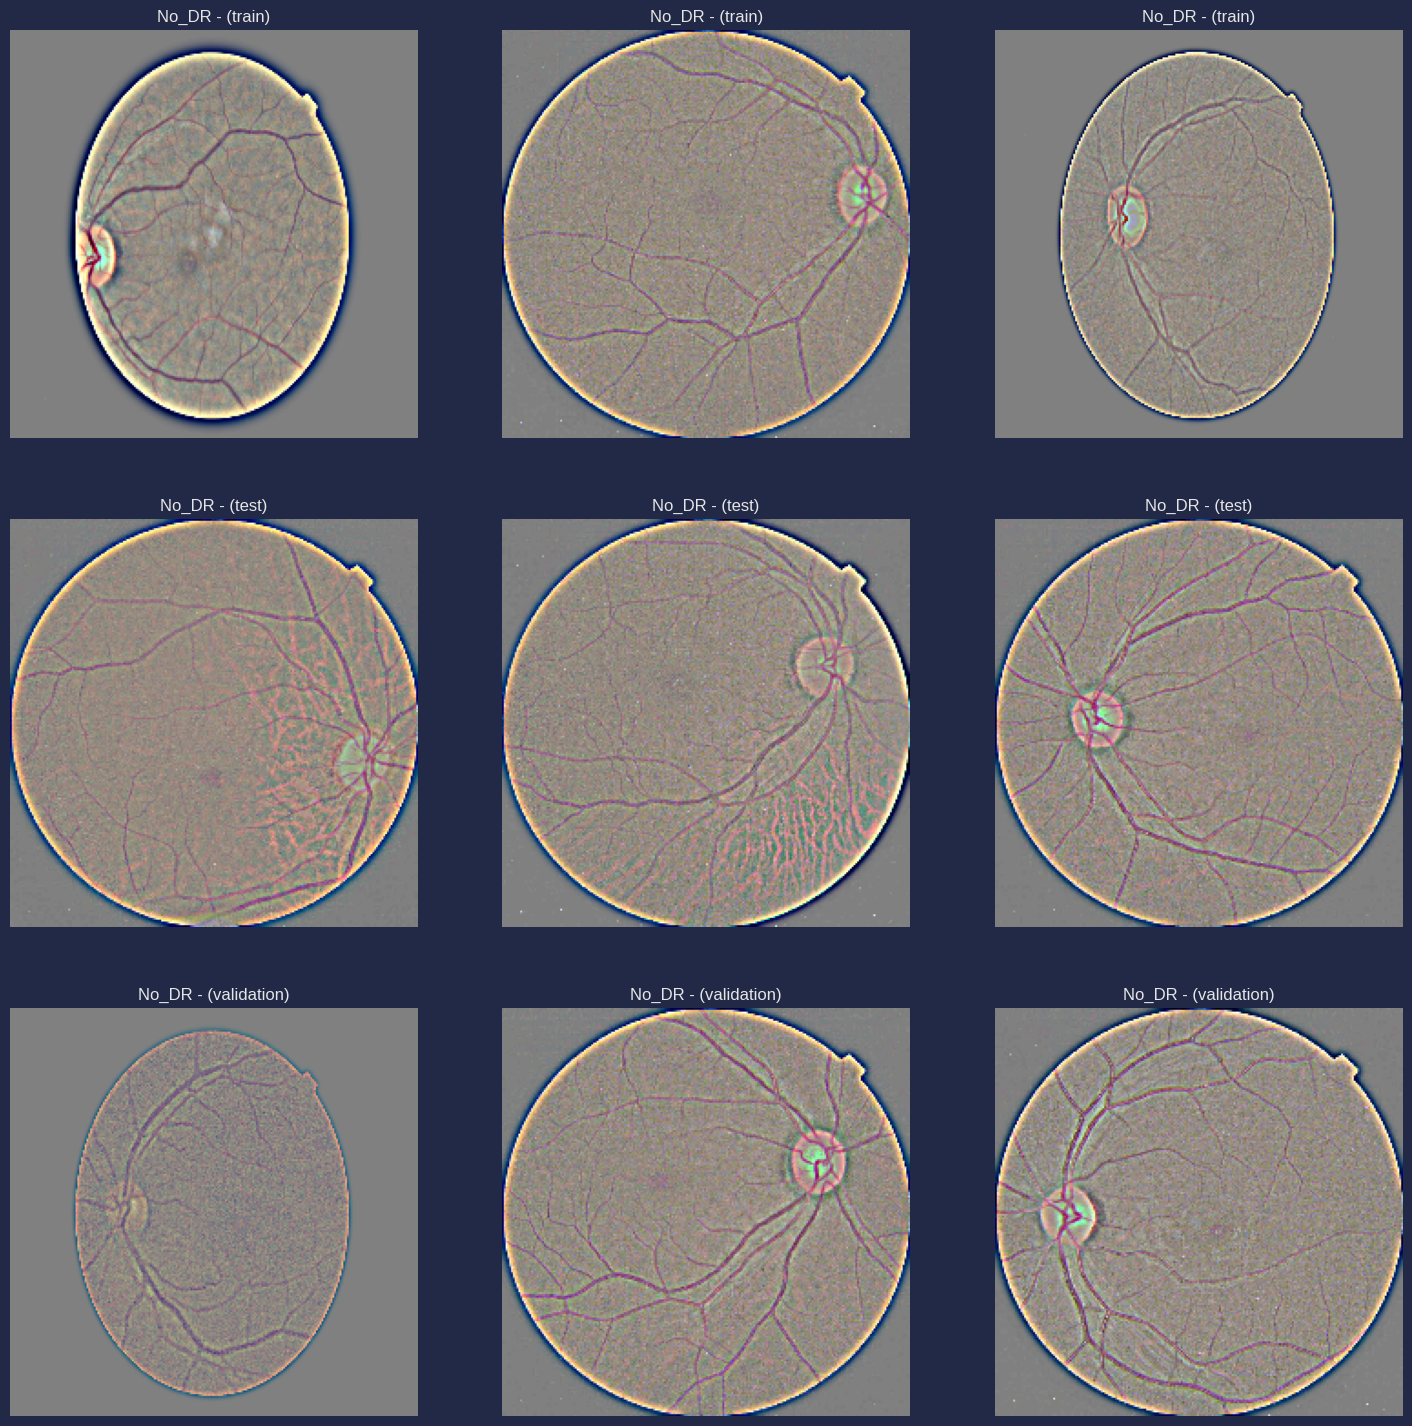

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18), sharey='col')

for i, name, data_gen in [*zip(range(3), ['train', 'test', 'validation'], [train_data, test_data, val_data])]:
    for j in range(3):
        n_batch, n_image = np.random.randint(32), np.random.randint(data_gen.n//32)
        ax[i][j].imshow(
            train_data[n_image][0][n_batch]
        )
        label = np.argmax(train_data[n_image][1][n_batch])
        ax[i][j].set_title(f'{["DR", "No_DR"][label]} - ({name})')
        ax[i][j].axis('off')

In [27]:
# base_model = tf.keras.applications.MobileNetV2(
#     include_top = False, 
#     input_shape=train_data.image_shape
# )
# base_model.trainable = False

# input = tf.keras.layers.Input(shape = train_data.image_shape)
# preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
# global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
# dense0 = tf.keras.layers.Dense(100, activation = 'relu')
# dense1 = tf.keras.layers.Dense(50, activation = 'relu')
# predict = tf.keras.layers.Dense(2, activation = 'sigmoid')

# x = preprocess(input)
# x = base_model(x)
# x = global_average_pooling(x)
# x = dense0(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = dense1(x)

# model = tf.keras.Model(input, predict(x))

9406464/9406464 [==============================] - 0s 0us/step


In [28]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [29]:
# primary_learning_rate = 5e-3

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=primary_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy',
#                        tf.keras.metrics.Precision(), 
#                        tf.keras.metrics.Recall()]
#               )

In [30]:
# model.evaluate(test_data)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 45s 1s/step - loss: 0.7158 - accuracy: 0.4934 - precision: 0.4934 - recall: 0.4934


[0.7157676219940186,
 0.49344977736473083,
 0.49344977736473083,
 0.49344977736473083]

In [31]:
# history = model.fit(train_data, epochs=50, validation_data=val_data)

Epoch 1/50
69/69 [==============================] - 143s 2s/step - loss: 0.7494 - accuracy: 0.5337 - precision: 0.5223 - recall: 0.5328 - val_loss: 0.6668 - val_accuracy: 0.8564 - val_precision: 0.5435 - val_recall: 1.0000
Epoch 2/50
69/69 [==============================] - 132s 2s/step - loss: 0.6861 - accuracy: 0.5383 - precision: 0.5400 - recall: 0.5569 - val_loss: 0.6541 - val_accuracy: 0.5709 - val_precision: 0.5699 - val_recall: 0.5782
Epoch 3/50
69/69 [==============================] - 131s 2s/step - loss: 0.6469 - accuracy: 0.6175 - precision: 0.6126 - recall: 0.6266 - val_loss: 0.5921 - val_accuracy: 0.6545 - val_precision: 0.6556 - val_recall: 0.5364
Epoch 4/50
69/69 [==============================] - 137s 2s/step - loss: 0.5779 - accuracy: 0.6831 - precision: 0.6877 - recall: 0.6799 - val_loss: 0.4715 - val_accuracy: 0.8273 - val_precision: 0.8309 - val_recall: 0.8218
Epoch 5/50
69/69 [==============================] - 135s 2s/step - loss: 0.5228 - accuracy: 0.7564 - precisi

In [32]:
# base_model.trainable = True

# for layer in base_model.layers[:150]:
#     layer.trainable = False

# fine_learning_rate = 1e-5

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy',
#                        tf.keras.metrics.Precision(), 
#                        tf.keras.metrics.Recall()]
#               )

In [33]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [34]:
# history_fine = model.fit(train_data, epochs=30, validation_data=val_data)

Epoch 1/30
69/69 [==============================] - 144s 2s/step - loss: 8.4583 - accuracy: 0.5469 - precision_1: 0.5459 - recall_1: 0.5546 - val_loss: 0.3589 - val_accuracy: 0.8727 - val_precision_1: 0.8727 - val_recall_1: 0.8727
Epoch 2/30
69/69 [==============================] - 138s 2s/step - loss: 2.0506 - accuracy: 0.6721 - precision_1: 0.6697 - recall_1: 0.6767 - val_loss: 0.3470 - val_accuracy: 0.8727 - val_precision_1: 0.8727 - val_recall_1: 0.8727
Epoch 3/30
69/69 [==============================] - 137s 2s/step - loss: 1.0551 - accuracy: 0.7072 - precision_1: 0.7063 - recall_1: 0.7086 - val_loss: 0.3438 - val_accuracy: 0.8691 - val_precision_1: 0.8691 - val_recall_1: 0.8691
Epoch 4/30
69/69 [==============================] - 138s 2s/step - loss: 0.6404 - accuracy: 0.7668 - precision_1: 0.7663 - recall_1: 0.7632 - val_loss: 0.3490 - val_accuracy: 0.8782 - val_precision_1: 0.8784 - val_recall_1: 0.8800
Epoch 5/30
69/69 [==============================] - 138s 2s/step - loss: 0.5

In [36]:
# model.evaluate(test_data)

29/29 [==============================] - 38s 1s/step - loss: 0.5096 - accuracy: 0.7838 - precision_1: 0.7862 - recall_1: 0.7828


[0.5095595121383667,
 0.7838428020477295,
 0.7861841917037964,
 0.7827510833740234]

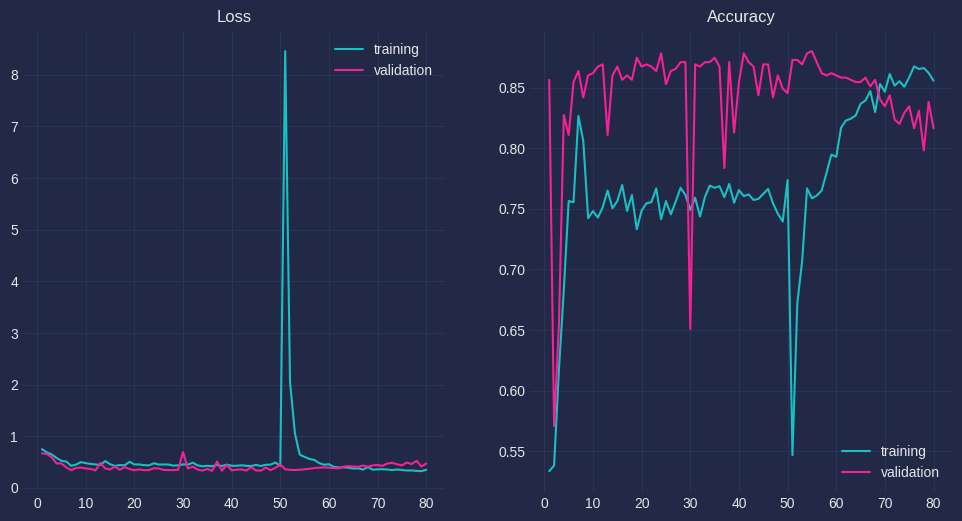

In [37]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# epochs = range(
#     1,
#     len(history.history['loss'])+len(history_fine.history['loss'])+1
# )

# ax[0].plot(
#     epochs,
#     history.history['loss']+history_fine.history['loss'], 
#     label='training'
# )
# ax[0].plot(
#     epochs,
#     history.history['val_loss']+history_fine.history['val_loss'], 
#     label='validation'
# )
# ax[0].set_title('Loss')
# ax[0].legend()

# ax[1].plot(
#     epochs,
#     history.history['accuracy']+history_fine.history['accuracy'],
#     label='training'
# )
# ax[1].plot(
#     epochs,
#     history.history['val_accuracy']+history_fine.history['val_accuracy'], 
#     label='validation'
# )
# ax[1].set_title('Accuracy')
# ax[1].legend()

In [16]:
input_layer = tf.keras.layers.Input(shape = (224, 224, 3))

max_pool = tf.keras.layers.MaxPooling2D(pool_size = (3, 3))

conv2d1 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'swish')
batch_norm1 = tf.keras.layers.BatchNormalization()

conv2d2 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'swish')
batch_norm2 = tf.keras.layers.BatchNormalization()

conv2d3 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'swish')
batch_norm3 = tf.keras.layers.BatchNormalization()

conv2d4 = tf.keras.layers.Conv2D(8, kernel_size = (3, 3), activation = 'swish')
batch_norm4 = tf.keras.layers.BatchNormalization()

flatten = tf.keras.layers.Flatten()

dense1 = tf.keras.layers.Dense(50, activation = 'swish')
dropout1 = tf.keras.layers.Dropout(.2)

predict = tf.keras.layers.Dense(2, activation = 'sigmoid')

x = input_layer

x = conv2d1(x)
x = max_pool(x)
x = batch_norm1(x)

x = conv2d2(x)
x = max_pool(x)
x = batch_norm2(x)

x = conv2d3(x)
x = max_pool(x)
x = batch_norm3(x)

x = flatten(x)
x = dense1(x)
x = dropout1(x)

model = tf.keras.Model(input_layer, predict(x))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 8)  224         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]']           

In [17]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
)

model.fit(
    train_data,
    epochs = 30,
    validation_data = val_data
)

Epoch 1/30
34/34 [==============================] - 39s 1s/step - loss: 0.5224 - accuracy: 0.7791 - val_loss: 0.6041 - val_accuracy: 1.0000
Epoch 2/30
34/34 [==============================] - 35s 1s/step - loss: 0.1898 - accuracy: 0.9926 - val_loss: 0.4361 - val_accuracy: 1.0000
Epoch 3/30
34/34 [==============================] - 38s 1s/step - loss: 0.1055 - accuracy: 0.9972 - val_loss: 0.2987 - val_accuracy: 1.0000
Epoch 4/30
34/34 [==============================] - 37s 1s/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 0.1996 - val_accuracy: 1.0000
Epoch 5/30
34/34 [==============================] - 36s 1s/step - loss: 0.0495 - accuracy: 0.9991 - val_loss: 0.1346 - val_accuracy: 1.0000
Epoch 6/30
34/34 [==============================] - 35s 1s/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0915 - val_accuracy: 1.0000
Epoch 7/30
34/34 [==============================] - 36s 1s/step - loss: 0.0304 - accuracy: 0.9991 - val_loss: 0.0640 - val_accuracy: 1.0000
Epoch 8/30
34/34 [==

In [18]:
model.evaluate(test_data)

15/15 [==============================] - 7s 410ms/step - loss: 8.9636e-04 - accuracy: 1.0000


[0.0008963566506281495, 1.0]

In [21]:
pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 52.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.9 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=f4290525ae04511dfd9f6c143c2ce41c5c575479d3fc9a804823d961c31945fe
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators


In [22]:
import streamlit as st

In [15]:
!streamlit run app2.py & npx localtunnel --port 8501

[##................] \ fetchMetadata: sill resolveWithNewModule ms@2.1.2 checki


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.71.204.93:8501

npx: installed 22 in 2.331s
your url is: https://eighty-poets-enter-34-71-204-93.loca.lt
  Stopping...
^C
